<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-of-the-problem---1-or-2-queues?" data-toc-modified-id="Introduction-of-the-problem---1-or-2-queues?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction of the problem - 1 or 2 queues?</a></span></li><li><span><a href="#1-server---1-queue" data-toc-modified-id="1-server---1-queue-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1 server - 1 queue</a></span><ul class="toc-item"><li><span><a href="#Generate-the-simulation-functions" data-toc-modified-id="Generate-the-simulation-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate the simulation functions</a></span></li><li><span><a href="#Compute-statistics-from-the-simulation-results" data-toc-modified-id="Compute-statistics-from-the-simulation-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compute statistics from the simulation results</a></span></li><li><span><a href="#Sweeping-parameter----lambda-(arrival-rate)" data-toc-modified-id="Sweeping-parameter----lambda-(arrival-rate)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sweeping parameter -- lambda (arrival rate)</a></span><ul class="toc-item"><li><span><a href="#Comparing-against-theoretical-results" data-toc-modified-id="Comparing-against-theoretical-results-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Comparing against theoretical results</a></span></li></ul></li></ul></li><li><span><a href="#1-queue---multiple-servers" data-toc-modified-id="1-queue---multiple-servers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>1 queue - multiple servers</a></span></li><li><span><a href="#2-queues---2-servers" data-toc-modified-id="2-queues---2-servers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2 queues - 2 servers</a></span></li></ul></div>

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# set the random number generator
np.random.seed(7)

# Introduction of the problem - 1 or 2 queues?

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters. In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster. So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep:
* I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.
* Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  
* But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.
* If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

# 1 server - 1 queue

## Generate the simulation functions

1. Write a function that creates **System** objects that we can initialise easily with the required parameters.
    * Remember that system objects were generated using "static" variables, whereas state objects changed from 1 moment of time to the next.
    * In this case, we will use `lam` and `mu` as input parameters
    * This System will also have a property `duration` to denote how long will the system will be active for. In this case, duration is given in minutes.

In [2]:
# Create a system object -> remember System variables were the ones that remained "static"
def make_system(lam, mu):
    """Make a System object.
    
    lam: arrival rate, per minute
    mu: service completion rate, per minute
    
    returns: System object
    """
    # duration is 10 hours * 60 minutes.
    system = System(lam=lam, mu=mu, duration = 10*60)
    return system

# Test function (lam=1/8 and mu=1/5)
s1 = make_system(lam=1/8,mu=1/5)
s1

,values
lam,0.125
mu,0.200
duration,600.000


2. Once we can create a System, we need a function to update the what is happening with the dynamic elements in the system. Given we are dealing with the queue system, we will generate a function to update:
    * Number of customers in the store
    * Time elapsed since the start of the system
    * In addition, it should use the probabilities or rates assigned to the system (`lam` and `mu`) to decide if a new customer has arrived or completed.

In [17]:
def update_func1(x, t, system):
    """Update function
    
    x: number of customers in the store
    t: number of minutes elapsed in the simulation
    system: system object with its specified rates and duration
    
    returns: 
    """
    # if there are no customers waiting in the queue, then the customer service point might be free (mu) and ready to attend a new arrival.
    if x > 0:
        if flip(system.mu):
            x = x - 1
    
    # in addition, there will be a chance that a new customer arrives to the store
    if flip(system.lam):
        x = x + 1
    
    return x

# Test the function
update_func1(x = 1, t = 0, system = s1)

1

3. Finally, we need to create a function to run a simulation:
    * We initiate the number of customers to 0
    * Create a TimeSeries object so that, for each iteration, we keep hold of the number of customers in store (result from update function)
    * Loop from t = 0 to the duration specified in the system

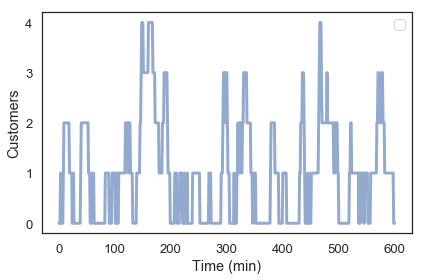

In [21]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

# Test the function
r1 = run_simulation(system = s1, update_func = update_func1)
plot(r1)
decorate(xlabel='Time (min)', ylabel='Customers')

## Compute statistics from the simulation results

After the simulation, for example, we can compute:
    * Average number of customers in the system (`L`)
    * Average time customers spend in the store (`W`)
    * Intuitively, `L` is proportional to `W`, ie, the longer customers wait, then more customers will be in the system. In other words something like $L=\lambda*W$
    * `L` is easily calculated with a mean
    * `W` is easily calculated with $L/lam$

In [22]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

In [23]:
compute_metrics(results = r1, system = s1)

(1.0016638935108153, 8.013311148086522)

## Sweeping parameter -- lambda (arrival rate)

* Up until now, we have initiated a system with $\lambda = 1/8$, but in reality, we don't have the data to back this up. In addition, this arrival rate might actually be dynamic within a same day, for example, longer queues to pay for a coffee at rush hour than in the evening.
* Now, obviously, if we know that at rush hour there is double the people than in the evenings, we might want to double the customer service points (if possible). Given we can't do that in this example due to the physical constraints of the shop, we can adjust the values of completion rates. For example, we can ask ourselves, what would be the arrival rate to the queue and shop if the completion rate was super low or super high.

In [24]:
# Generate an array of arrival rates
mu = 1/5
lam_array = linspace(0.1*mu, 0.8*mu, 100)
lam_array

array([0.02      , 0.02141414, 0.02282828, 0.02424242, 0.02565657,
       0.02707071, 0.02848485, 0.02989899, 0.03131313, 0.03272727,
       0.03414141, 0.03555556, 0.0369697 , 0.03838384, 0.03979798,
       0.04121212, 0.04262626, 0.0440404 , 0.04545455, 0.04686869,
       0.04828283, 0.04969697, 0.05111111, 0.05252525, 0.05393939,
       0.05535354, 0.05676768, 0.05818182, 0.05959596, 0.0610101 ,
       0.06242424, 0.06383838, 0.06525253, 0.06666667, 0.06808081,
       0.06949495, 0.07090909, 0.07232323, 0.07373737, 0.07515152,
       0.07656566, 0.0779798 , 0.07939394, 0.08080808, 0.08222222,
       0.08363636, 0.08505051, 0.08646465, 0.08787879, 0.08929293,
       0.09070707, 0.09212121, 0.09353535, 0.09494949, 0.09636364,
       0.09777778, 0.09919192, 0.10060606, 0.1020202 , 0.10343434,
       0.10484848, 0.10626263, 0.10767677, 0.10909091, 0.11050505,
       0.11191919, 0.11333333, 0.11474747, 0.11616162, 0.11757576,
       0.1189899 , 0.12040404, 0.12181818, 0.12323232, 0.12464

In [26]:
def sweep_lam(lam_array,mu,update_function):
    """Run simulations with a range of values for `lam`
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    update_func: passed along to run_simulation
    
    returns: SweepSeries of average wait time vs lam
    """
    
    sweep = SweepSeries()
    
    for lam in lam_array:
        system = make_system(lam, mu)
        results = run_simulation(system, update_function)
        L, W = compute_metrics(results, system)
        sweep[lam] = W
        
    return sweep

# Test function
sweep = sweep_lam(lam_array, mu, update_func1)

,values
0.020000,5.990017
0.021414,7.459266
0.022828,4.008805
0.024242,4.598586
0.025657,3.566890
0.027071,5.531825
0.028485,7.301660
0.029899,11.297050
0.031313,7.917449
0.032727,3.558883


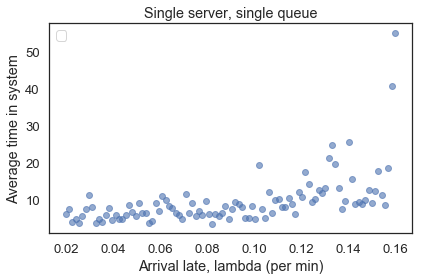

In [27]:
plot(sweep, 'bo')

decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

### Comparing against theoretical results

The plot above shows the results of our simulation. If we abstracted to the theoretical beahaviour of what should happen, how would that compare against our simulated results?

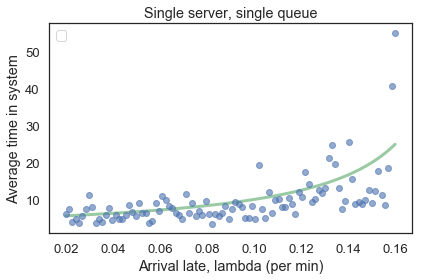

In [28]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')
    
plot_W(lam_array, mu)
plot(sweep, 'bo')

decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

In [29]:
sweep.mean()

9.603784370228361

# 1 queue - multiple servers

So, let's say that we find unacceptable that the average waiting time is ~9 minutes. The company wants to investigate if adding a new server to do the checkpoint is viable. They want to know how much waiting time could be cut. 

In [41]:
def update_func2(x, t, system):
    """Update function
    
    x: number of customers in the store
    t: number of minutes elapsed in the simulation
    system: system object with its specified rates and duration
    
    returns: 
    """
    # if there is already a customer being attended in service point check number 1, then check if the second service point is free (mu)
    if x > 1:
        if flip(system.mu):
            x = x - 1
    
    # if there are no customers in the queue, then any of the 2 service points might be ready (mu) to attend a possible new customer
    if x > 0:
        if flip(system.mu):
            x = x - 1
    
    # in addition, there will be a chance that a new customer arrives to the store
    if flip(system.lam):
        x = x + 1
    
    return x

# Test running in simulation
lam_array = linspace(0.1*mu, 1.6*mu, 100)
sweep = sweep_lam(lam_array, mu, update_func2)

,values
0.020000,7.737105
0.023030,5.418601
0.026061,4.533142
0.029091,3.431780
0.032121,4.403039
0.035152,3.124104
0.038182,5.752318
0.041212,6.096457
0.044242,5.378023
0.047273,5.455651


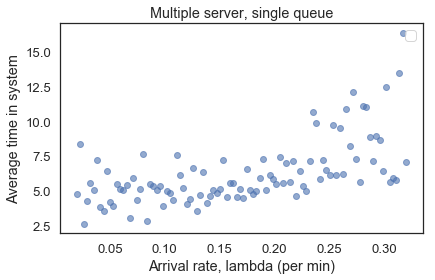

In [34]:
plot(sweep, 'bo')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

In [37]:
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.278073354087055 minutes


# 2 queues - 2 servers

Finally, the company wants to understand if by investing in space in the store to be able to generate 2 queues, will speed up the completion rate.

In [44]:
def update_func3(x1, x2, t, system):
    """Simulate two queues with one server each.
    
    x1: number of customers in queue 1
    x2: number of customers in queue 2
    t: time step
    system: System object
    """
    # if the first servers is busy, check it it's done
    if x1 > 0 and flip(system.mu):
        x1 -= 1
            
    # if the second queue is busy, check if it's done
    if x2 > 0 and flip(system.mu):
        x2 -= 1
            
    # check for an arrival
    if flip(system.lam):
        # join whichever queue is shorter
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1
            
    return x1, x2

def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2
    
    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2

    return results

In [46]:
# Test running in simulation
lam_array = linspace(0.1*mu, 1.6*mu, 100)
sweep = sweep_lam(lam_array, mu, update_func3)

,values
0.020000,1.913478
0.023030,3.395656
0.026061,5.682390
0.029091,3.660566
0.032121,7.459266
0.035152,6.674221
0.038182,7.539022
0.041212,7.630665
0.044242,4.174549
0.047273,5.209267


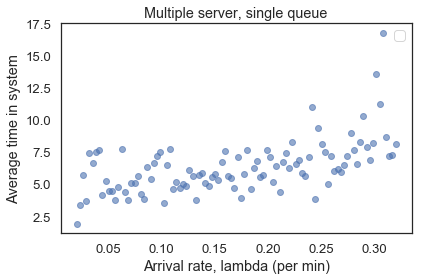

In [47]:
plot(sweep, 'bo')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

In [48]:
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.362400116861747 minutes


From the results, it doesn't look like there is much of a difference or even an improvement. Clearly, the improvement comes from adding more check out point (which is obvious). There might be intangibles though as to why to add 1 or 2 queues in the shop (maybe 1 long queue is a deterrant for customers, maybe the space is better optimised by having 2 queues instead of 1, etc).